In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=45a0fca5e88a5af1b94cbf2be81da97e3f0ad674618fb0d9338edef6e2aa7f22
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/LoanPrediction.csv'

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LoanEligibilityPrediction") \
    .getOrCreate()

df = spark.read.csv(file_path, header=True, inferSchema=True)

In [5]:
df.columns

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'Loan_Status']

In [6]:
df.show(5)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      NULL|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [7]:
df.orderBy("Loan_ID", ascending=False).limit(5).show()

+--------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP002990|Female|     No|         0| Graduate|          Yes|           4583|              0.0|       133|             360|             0|    Semiurban|          N|
|LP002984|  Male|    Yes|         2| Graduate|           No|           7583|              0.0|       187|             360|             1|        Urban|          Y|
|LP002983|  Male|    Yes|         1| Graduate|           No|           8072|            240.0|       253|             360|             1|        Urban|          Y|
|LP002979|  Male

In [8]:
df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



In [9]:
df.describe().show()

+-------+--------+------+-------+------------------+------------+-------------+-----------------+------------------+------------------+-----------------+------------------+-------------+-----------+
|summary| Loan_ID|Gender|Married|        Dependents|   Education|Self_Employed|  ApplicantIncome| CoapplicantIncome|        LoanAmount| Loan_Amount_Term|    Credit_History|Property_Area|Loan_Status|
+-------+--------+------+-------+------------------+------------+-------------+-----------------+------------------+------------------+-----------------+------------------+-------------+-----------+
|  count|     614|   601|    611|               599|         614|          582|              614|               614|               592|              600|               564|          614|        614|
|   mean|    NULL|  NULL|   NULL|0.5547445255474452|        NULL|         NULL|5403.459283387622| 1621.245798027101|146.41216216216216|            342.0|0.8421985815602837|         NULL|       NULL|
| std

In [10]:
df.dtypes

[('Loan_ID', 'string'),
 ('Gender', 'string'),
 ('Married', 'string'),
 ('Dependents', 'string'),
 ('Education', 'string'),
 ('Self_Employed', 'string'),
 ('ApplicantIncome', 'int'),
 ('CoapplicantIncome', 'double'),
 ('LoanAmount', 'int'),
 ('Loan_Amount_Term', 'int'),
 ('Credit_History', 'int'),
 ('Property_Area', 'string'),
 ('Loan_Status', 'string')]

In [11]:
from pyspark.sql.functions import col, sum

duplicates = df.groupBy(df.columns).count().filter(col("count") > 1)

print("Duplicate Rows:")
duplicates.show(vertical=True)

Duplicate Rows:
(0 rows)



In [12]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show(vertical=True)

-RECORD 0----------------
 Loan_ID           | 0   
 Gender            | 13  
 Married           | 3   
 Dependents        | 15  
 Education         | 0   
 Self_Employed     | 32  
 ApplicantIncome   | 0   
 CoapplicantIncome | 0   
 LoanAmount        | 22  
 Loan_Amount_Term  | 14  
 Credit_History    | 50  
 Property_Area     | 0   
 Loan_Status       | 0   



In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

In [14]:
data_pandas = df.toPandas()

data_copy = data_pandas.copy()

In [15]:
data_copy.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [16]:
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

for col in categorical_cols:
  mode = data_copy[col].mode()[0]
  data_copy[col].fillna(mode, inplace=True)

In [17]:
numerical_cols = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'ApplicantIncome', 'CoapplicantIncome']

iter_imputer = IterativeImputer(max_iter=10, random_state=0)
data_copy[numerical_cols] = iter_imputer.fit_transform(data_copy[numerical_cols])
data_copy[numerical_cols] = data_copy[numerical_cols].round()

In [18]:
print(data_copy.head())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0           5849.0                0.0       138.0             360.0   
1           4583.0             1508.0       128.0             360.0   
2           3000.0                0.0        66.0             360.0   
3           2583.0             2358.0       120.0             360.0   
4           6000.0                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [19]:
data_copy.isnull().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [20]:
data_copy.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245928,146.250814,342.011401,0.855049
std,6109.041673,2926.248406,84.284566,64.373134,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,165.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [21]:
data_copy = data_copy.drop('Loan_ID', axis=1)

In [22]:
print(data_copy.columns)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


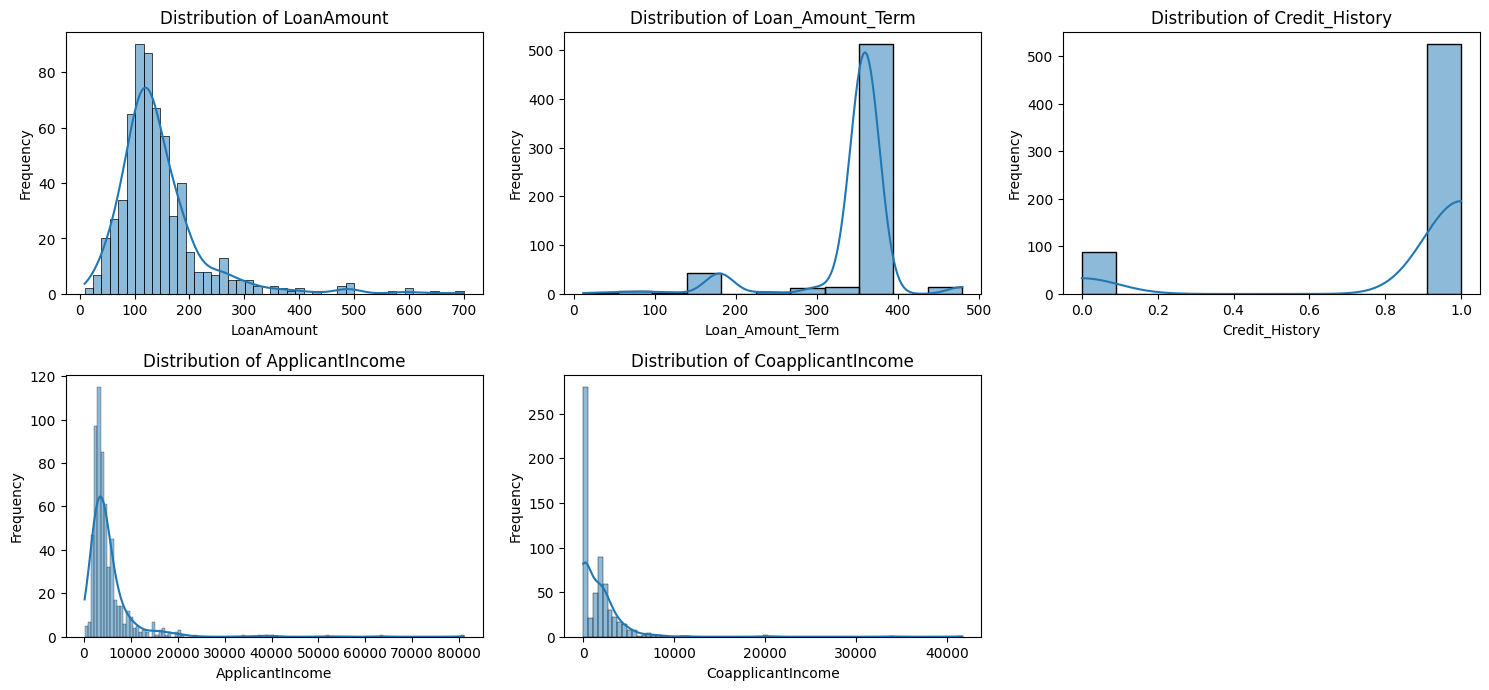

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data_copy[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

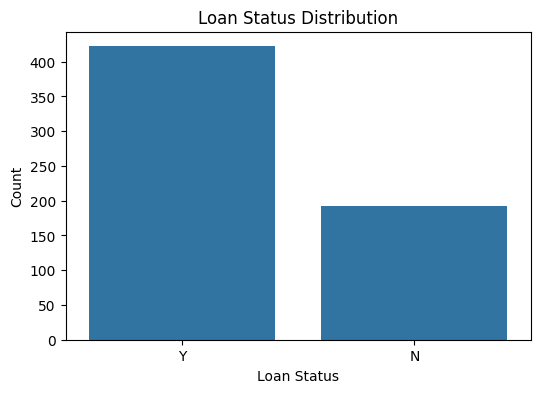

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x='Loan_Status', data=data_copy)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

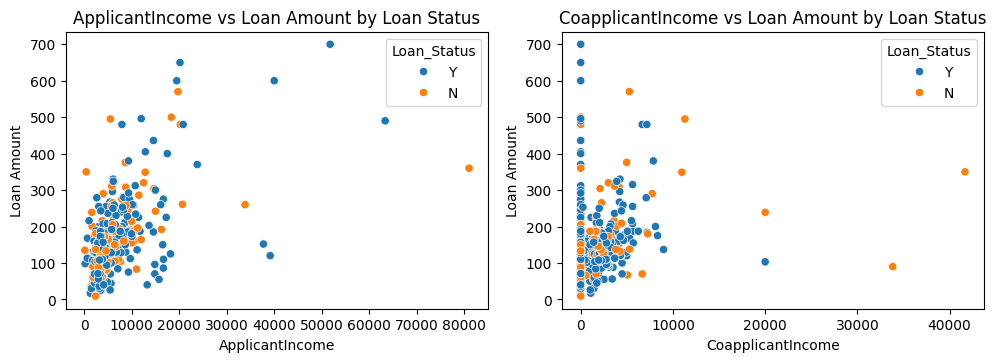

In [25]:
income = ['ApplicantIncome', 'CoapplicantIncome']

plt.figure(figsize=(15, 10))
for i, col in enumerate(income, 1):
  plt.subplot(3, 3, i)
  sns.scatterplot(x=data_copy[col], y='LoanAmount', hue='Loan_Status', data=data_copy)
  plt.title(f'{col} vs Loan Amount by Loan Status')
  plt.xlabel(col)
  plt.ylabel('Loan Amount')

plt.tight_layout()
plt.show()

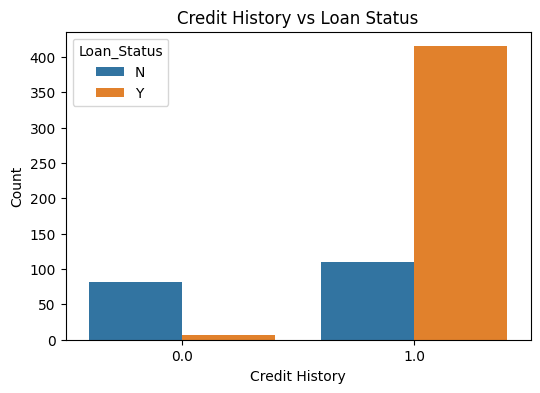

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x='Credit_History', hue='Loan_Status', data=data_copy)
plt.title('Credit History vs Loan Status')
plt.xlabel('Credit History')
plt.ylabel('Count')
plt.show()

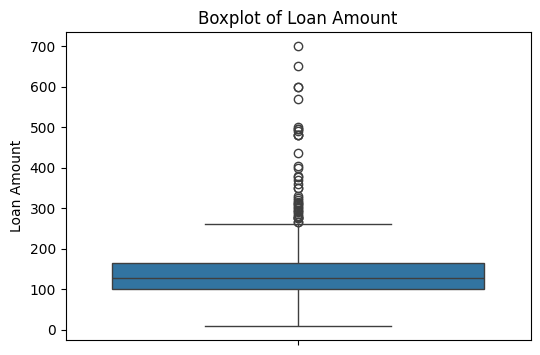

In [27]:
plt.figure(figsize=(6,4))
sns.boxplot(y='LoanAmount', data=data_copy)
plt.title('Boxplot of Loan Amount')
plt.ylabel('Loan Amount')
plt.show()

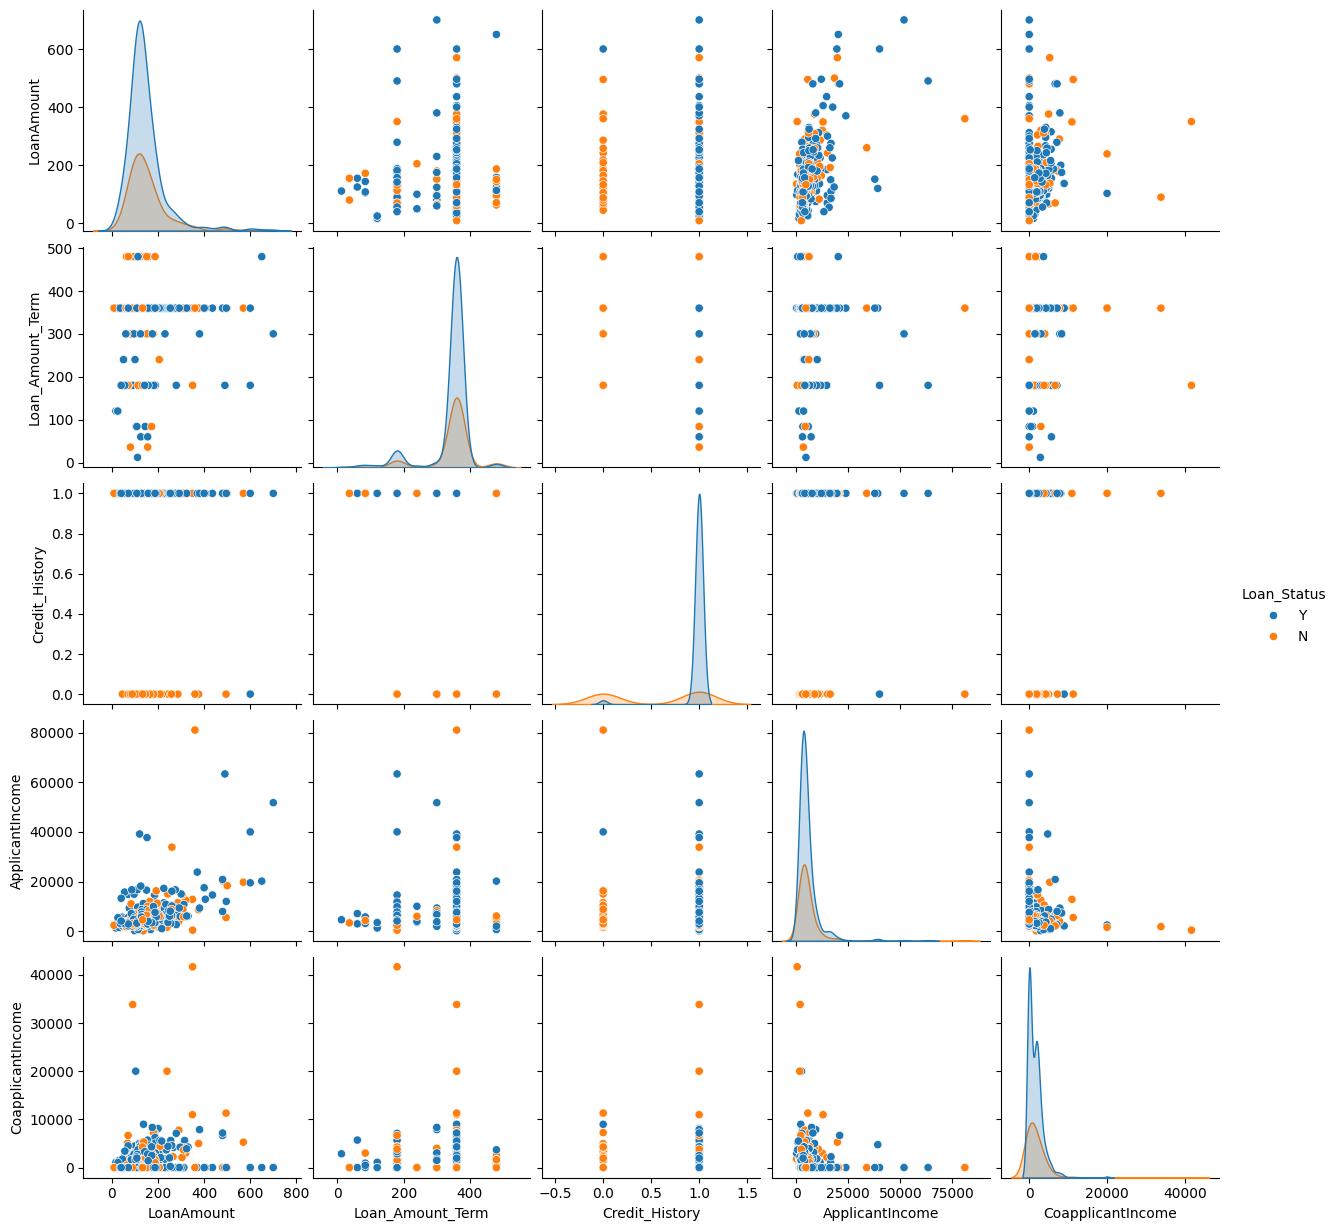

In [28]:
sns.pairplot(data_pandas[numerical_cols + ['Loan_Status']], hue='Loan_Status')
plt.show()

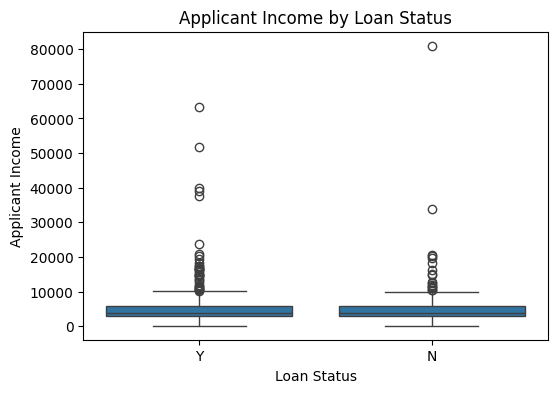

In [29]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=data_copy)
plt.title('Applicant Income by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Applicant Income')
plt.show()

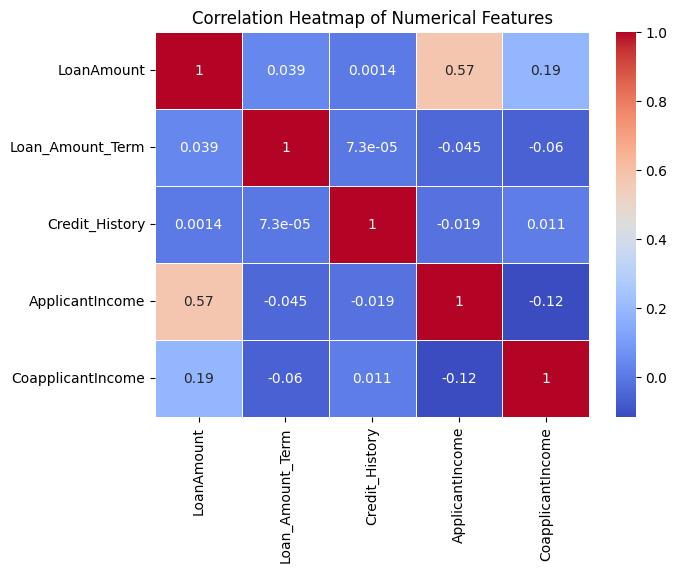

In [30]:
plt.figure(figsize=(7,5))
sns.heatmap(data_copy[numerical_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

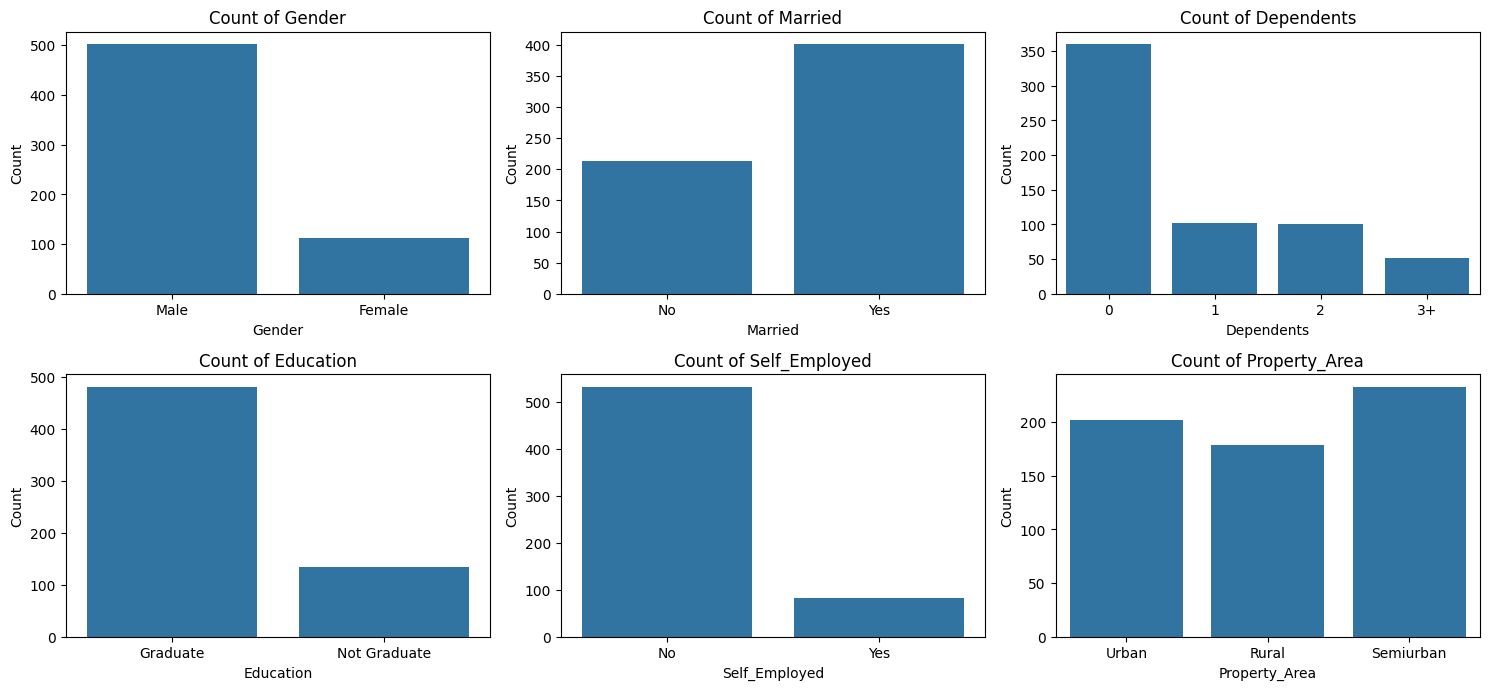

In [31]:
categories = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categories, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=col, data=data_copy)
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [32]:
data_spark_preprocessed = spark.createDataFrame(data_copy)

In [33]:
data_spark_preprocessed.show(10)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|  Male|     No|         0|    Graduate|           No|         5849.0|              0.0|     138.0|           360.0|           1.0|        Urban|          Y|
|  Male|    Yes|         1|    Graduate|           No|         4583.0|           1508.0|     128.0|           360.0|           1.0|        Rural|          N|
|  Male|    Yes|         0|    Graduate|          Yes|         3000.0|              0.0|      66.0|           360.0|           1.0|        Urban|          Y|
|  Male|    Yes|         0|Not Graduate|           N

In [34]:
print(type(data_spark_preprocessed))

<class 'pyspark.sql.dataframe.DataFrame'>


In [35]:
data_spark_preprocessed.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: double (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: double (nullable = true)
 |-- Credit_History: double (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



In [36]:
def calculate_iqr(df, column):
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    return q1, q3, iqr

columns_to_check = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

iqr_values = {col: calculate_iqr(data_spark_preprocessed, col) for col in columns_to_check}

for col, (q1, q3, iqr) in iqr_values.items():
    print(f"Column: {col} | Q1: {q1}, Q3: {q3}, IQR: {iqr}")

Column: ApplicantIncome | Q1: 2873.0, Q3: 5708.0, IQR: 2835.0
Column: CoapplicantIncome | Q1: 0.0, Q3: 2250.0, IQR: 2250.0
Column: LoanAmount | Q1: 100.0, Q3: 162.0, IQR: 62.0
Column: Loan_Amount_Term | Q1: 360.0, Q3: 360.0, IQR: 0.0


In [37]:
iqr_values.pop('Loan_Amount_Term', None)

for col, (q1, q3, iqr) in iqr_values.items():
    print(f"Column: {col} | Q1: {q1}, Q3: {q3}, IQR: {iqr}")

Column: ApplicantIncome | Q1: 2873.0, Q3: 5708.0, IQR: 2835.0
Column: CoapplicantIncome | Q1: 0.0, Q3: 2250.0, IQR: 2250.0
Column: LoanAmount | Q1: 100.0, Q3: 162.0, IQR: 62.0


In [38]:
from pyspark.sql.functions import col

def remove_outliers(df, column, iqr_values):
    q1, q3, iqr = iqr_values[column]
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

for column in iqr_values:
    data_spark_preprocessed = remove_outliers(data_spark_preprocessed, column, iqr_values)

data_spark_preprocessed.describe().show()

+-------+------+-------+------------------+------------+-------------+------------------+------------------+------------------+-----------------+-------------------+-------------+-----------+
|summary|Gender|Married|        Dependents|   Education|Self_Employed|   ApplicantIncome| CoapplicantIncome|        LoanAmount| Loan_Amount_Term|     Credit_History|Property_Area|Loan_Status|
+-------+------+-------+------------------+------------+-------------+------------------+------------------+------------------+-----------------+-------------------+-------------+-----------+
|  count|   524|    524|               524|         524|          524|               524|               524|               524|              524|                524|          524|        524|
|   mean|  NULL|   NULL| 0.534020618556701|        NULL|         NULL|3966.7385496183206|1308.1889312977098|124.75954198473282|342.9293893129771| 0.8530534351145038|         NULL|       NULL|
| stddev|  NULL|   NULL|0.78293875798018

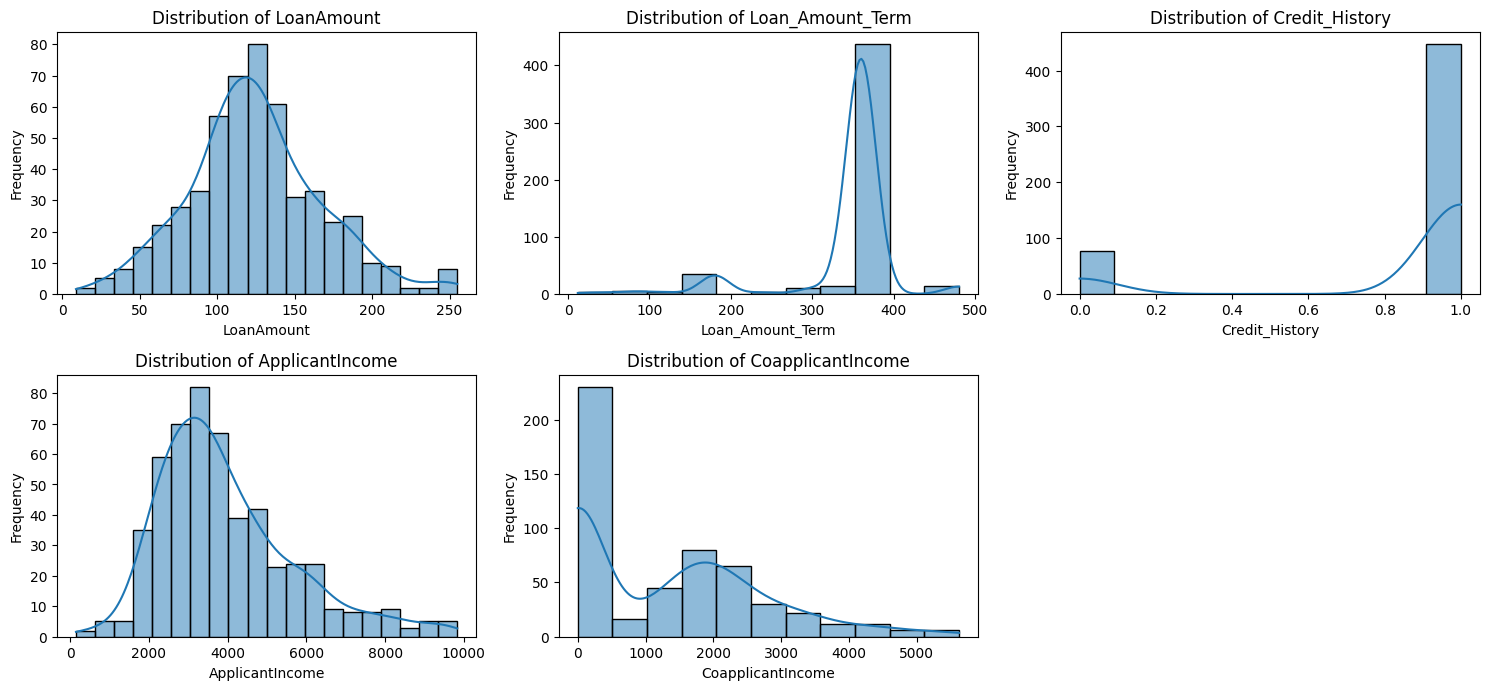

In [39]:
data_pandas = data_spark_preprocessed.toPandas()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data_pandas[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [40]:
data_preprocessed = spark.createDataFrame(data_pandas)

In [41]:
from pyspark.sql.functions import col

data = data_preprocessed.withColumn('TotalIncome', col('ApplicantIncome') + col('CoapplicantIncome'))
data.show(5)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+
|  Male|     No|         0|    Graduate|           No|         5849.0|              0.0|     138.0|           360.0|           1.0|        Urban|          Y|     5849.0|
|  Male|    Yes|         1|    Graduate|           No|         4583.0|           1508.0|     128.0|           360.0|           1.0|        Rural|          N|     6091.0|
|  Male|    Yes|         0|    Graduate|          Yes|         3000.0|              0.0|      66.0|           360.0|           1.0|        Urban|     

In [42]:
data = data.withColumn('IncomeToLoanRatio', col('TotalIncome') / col('LoanAmount'))
data.show(5)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+-----------------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|IncomeToLoanRatio|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+-----------------+
|  Male|     No|         0|    Graduate|           No|         5849.0|              0.0|     138.0|           360.0|           1.0|        Urban|          Y|     5849.0|42.38405797101449|
|  Male|    Yes|         1|    Graduate|           No|         4583.0|           1508.0|     128.0|           360.0|           1.0|        Rural|          N|     6091.0|       47.5859375|
|  Male|    Yes|         0|    Graduate|          Yes|      

In [43]:
from pyspark.sql.functions import when

data = data.withColumn('Property_Area_Credit_History',
                       when((col('Property_Area') == 'Urban') & (col('Credit_History') == 1), 1)
                       .otherwise(0))

data.show(5)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+-----------------+----------------------------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|IncomeToLoanRatio|Property_Area_Credit_History|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+-----------+-----------------+----------------------------+
|  Male|     No|         0|    Graduate|           No|         5849.0|              0.0|     138.0|           360.0|           1.0|        Urban|          Y|     5849.0|42.38405797101449|                           1|
|  Male|    Yes|         1|    Graduate|           No|         4583.0|           1508.0|     128.0|           360.0|           1.0| 

In [44]:
data = data.withColumn('Education_Self_Employed',
                       when((col('Education') == 'Graduate') & (col('Self_Employed') == 'Yes'), 1)
                       .otherwise(0))

In [45]:
data = data.withColumn(
    'Loan_Amount_Term_Category',
    when(col('Loan_Amount_Term') <= 180, 'Short Term')
    .when((col('Loan_Amount_Term') > 180) & (col('Loan_Amount_Term') <= 300), 'Medium Term')
    .otherwise('Long Term'))

In [46]:
data = data.withColumn("LoanAmountCategory",
    when(col("LoanAmount") <= 100, "Low")
    .when((col("LoanAmount") > 100) & (col("LoanAmount") <= 168), "Medium")
    .otherwise("High"))

data.groupBy("LoanAmountCategory").count().show()

+------------------+-----+
|LoanAmountCategory|count|
+------------------+-----+
|              High|   79|
|               Low|  146|
|            Medium|  299|
+------------------+-----+



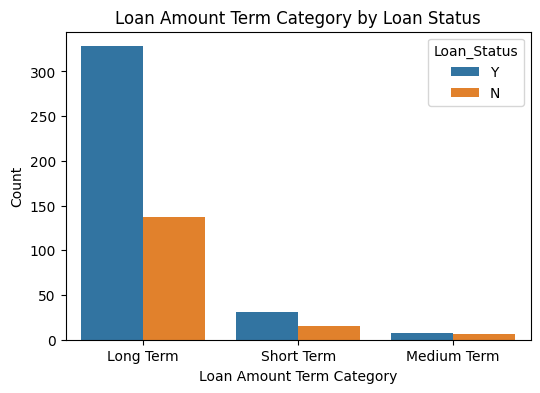

In [47]:
data_pandas = data.toPandas()

plt.figure(figsize=(6,4))
sns.countplot(x='Loan_Amount_Term_Category', hue='Loan_Status', data=data_pandas)
plt.title('Loan Amount Term Category by Loan Status')
plt.xlabel('Loan Amount Term Category')
plt.ylabel('Count')
plt.show()

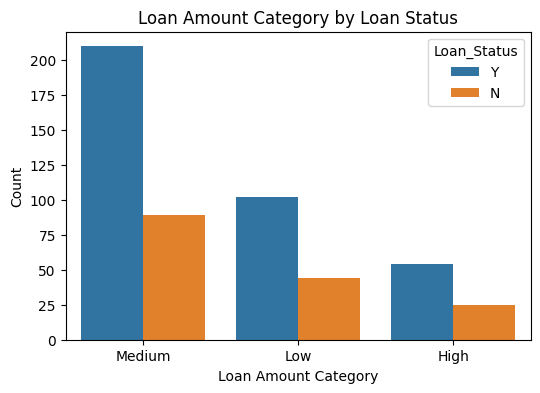

In [48]:
plt.figure(figsize=(6,4))
sns.countplot(x='LoanAmountCategory', hue='Loan_Status', data=data_pandas)
plt.title('Loan Amount Category by Loan Status')
plt.xlabel('Loan Amount Category')
plt.ylabel('Count')
plt.show()

In [49]:
data = spark.createDataFrame(data_pandas)
print(type(data))

<class 'pyspark.sql.dataframe.DataFrame'>


In [50]:
data.columns

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'Loan_Status',
 'TotalIncome',
 'IncomeToLoanRatio',
 'Property_Area_Credit_History',
 'Education_Self_Employed',
 'Loan_Amount_Term_Category',
 'LoanAmountCategory']

In [51]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status', 'Loan_Amount_Term_Category', 'LoanAmountCategory']

indexers = [StringIndexer(inputCol=col, outputCol=col+"_Index") for col in categorical_cols]
pipeline = Pipeline(stages=indexers)

data_indexed = pipeline.fit(data).transform(data)

data_indexed.select([col+"_Index" for col in categorical_cols]).show(5)

+------------+-------------+----------------+---------------+-------------------+-------------------+-----------------+-------------------------------+------------------------+
|Gender_Index|Married_Index|Dependents_Index|Education_Index|Self_Employed_Index|Property_Area_Index|Loan_Status_Index|Loan_Amount_Term_Category_Index|LoanAmountCategory_Index|
+------------+-------------+----------------+---------------+-------------------+-------------------+-----------------+-------------------------------+------------------------+
|         0.0|          1.0|             0.0|            0.0|                0.0|                1.0|              0.0|                            0.0|                     0.0|
|         0.0|          0.0|             2.0|            0.0|                0.0|                2.0|              1.0|                            0.0|                     0.0|
|         0.0|          0.0|             0.0|            0.0|                1.0|                1.0|              

In [52]:
data_indexed.columns

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'Loan_Status',
 'TotalIncome',
 'IncomeToLoanRatio',
 'Property_Area_Credit_History',
 'Education_Self_Employed',
 'Loan_Amount_Term_Category',
 'LoanAmountCategory',
 'Gender_Index',
 'Married_Index',
 'Dependents_Index',
 'Education_Index',
 'Self_Employed_Index',
 'Property_Area_Index',
 'Loan_Status_Index',
 'Loan_Amount_Term_Category_Index',
 'LoanAmountCategory_Index']

In [53]:
data_indexed = data_indexed.drop(*categorical_cols)

data_indexed.columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'TotalIncome',
 'IncomeToLoanRatio',
 'Property_Area_Credit_History',
 'Education_Self_Employed',
 'Gender_Index',
 'Married_Index',
 'Dependents_Index',
 'Education_Index',
 'Self_Employed_Index',
 'Property_Area_Index',
 'Loan_Status_Index',
 'Loan_Amount_Term_Category_Index',
 'LoanAmountCategory_Index']

In [84]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'IncomeToLoanRatio',
                  'Property_Area_Credit_History', 'Education_Self_Employed']

assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_features')

scaler = StandardScaler(inputCol='numerical_features', outputCol='scaled_features', withMean=True, withStd=True)

scaling_pipeline = Pipeline(stages=[assembler, scaler])

data_scaled = scaling_pipeline.fit(data_indexed).transform(data_indexed)

data_scaled.select('scaled_features').show(5)

+--------------------+
|     scaled_features|
+--------------------+
|[1.08298070201271...|
|[0.35457308973861...|
|[-0.5562241063355...|
|[-0.7961498364447...|
|[1.16986028293956...|
+--------------------+
only showing top 5 rows



In [85]:
data_scaled.columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'TotalIncome',
 'IncomeToLoanRatio',
 'Property_Area_Credit_History',
 'Education_Self_Employed',
 'Gender_Index',
 'Married_Index',
 'Dependents_Index',
 'Education_Index',
 'Self_Employed_Index',
 'Property_Area_Index',
 'Loan_Status_Index',
 'Loan_Amount_Term_Category_Index',
 'LoanAmountCategory_Index',
 'numerical_features',
 'scaled_features']

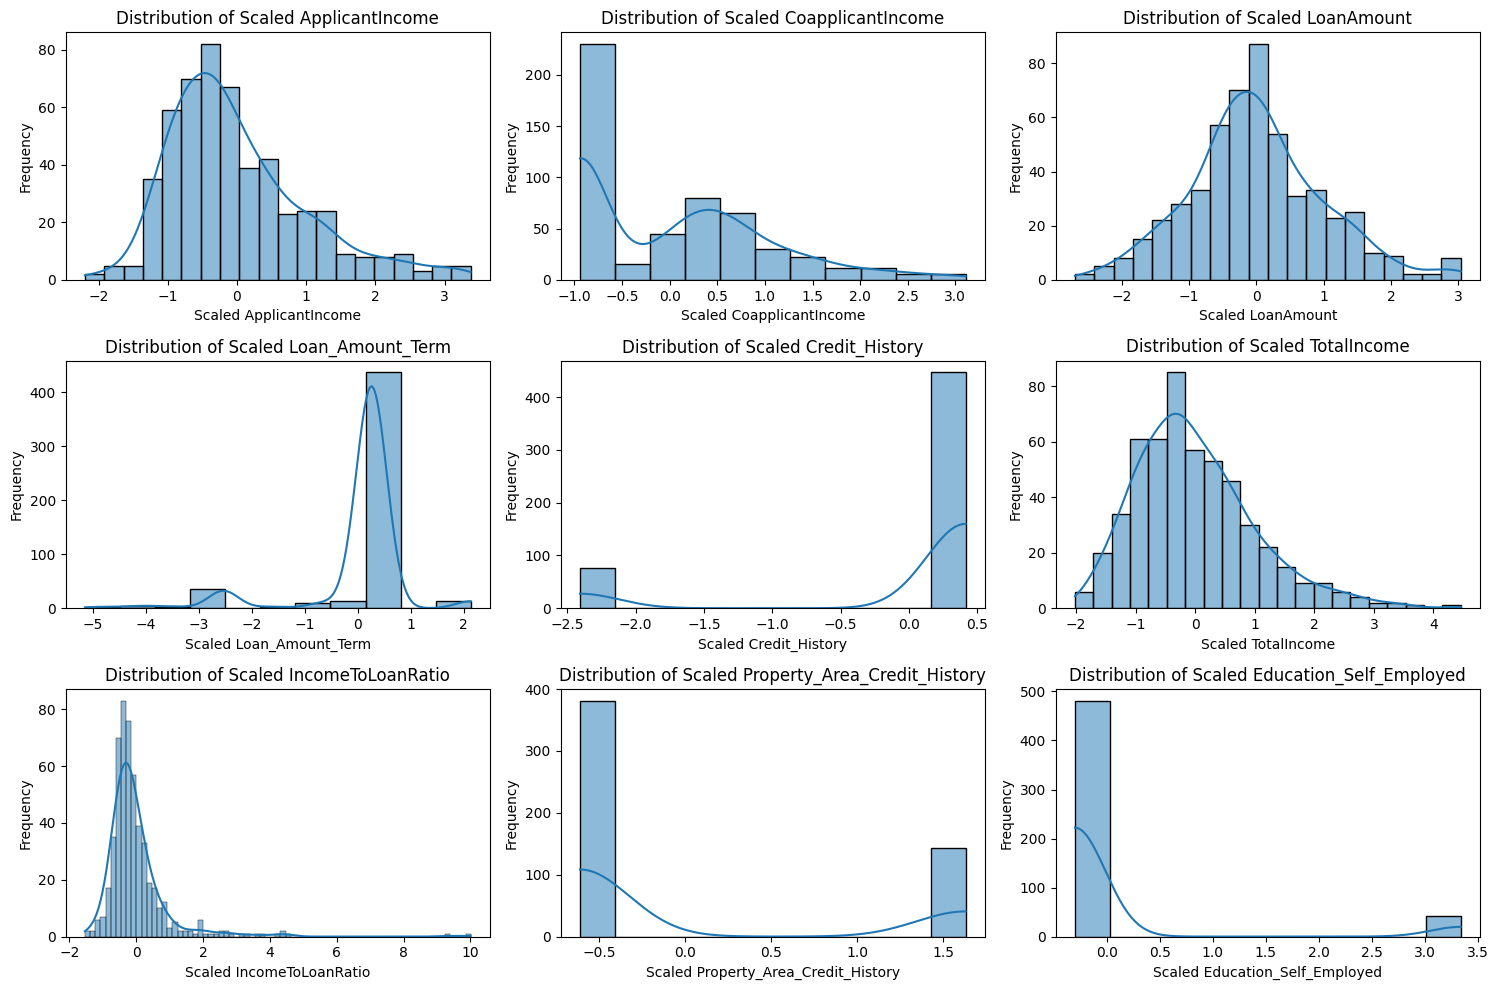

In [89]:
scaled_features_list = data_scaled.select('scaled_features').rdd.map(lambda row: row['scaled_features'].toArray()).collect()

scaled_features_df = pd.DataFrame(scaled_features_list, columns=numerical_cols)

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(scaled_features_df[col], kde=True)
    plt.title(f'Distribution of Scaled {col}')
    plt.xlabel(f'Scaled {col}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [56]:
from pyspark.ml.feature import ChiSqSelector

all_features = numerical_cols + ['Gender_Index', 'Married_Index', 'Dependents_Index', 'Education_Index', 'Self_Employed_Index', 'Property_Area_Index', 'Loan_Amount_Term_Category_Index', 'LoanAmountCategory_Index']

assembler = VectorAssembler(inputCols=all_features, outputCol="features")
data_with_features = assembler.transform(data_scaled)

selector = ChiSqSelector(featuresCol="features", outputCol="selected_features", labelCol="Loan_Status_Index")

data_selected = selector.fit(data_with_features).transform(data_with_features)

data_selected.columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'TotalIncome',
 'IncomeToLoanRatio',
 'Property_Area_Credit_History',
 'Education_Self_Employed',
 'Gender_Index',
 'Married_Index',
 'Dependents_Index',
 'Education_Index',
 'Self_Employed_Index',
 'Property_Area_Index',
 'Loan_Status_Index',
 'Loan_Amount_Term_Category_Index',
 'LoanAmountCategory_Index',
 'numerical_features',
 'scaled_features',
 'features',
 'selected_features']

In [57]:
train_data, test_data = data_selected.randomSplit([0.8, 0.2], seed=42)

In [58]:
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [59]:
auc_evaluator = BinaryClassificationEvaluator(labelCol="Loan_Status_Index", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

models = {
    "Decision Tree": DecisionTreeClassifier(labelCol="Loan_Status_Index", featuresCol="selected_features"),
    "Logistic Regression": LogisticRegression(labelCol="Loan_Status_Index", featuresCol="selected_features"),
    "Random Forest": RandomForestClassifier(labelCol="Loan_Status_Index", featuresCol="selected_features")
}

for model_name, model in models.items():
    print(f"Training {model_name}...")

    model_fitted = model.fit(train_data)
    predictions = model_fitted.transform(test_data)

    auc = auc_evaluator.evaluate(predictions)

    tp = predictions.filter((col('prediction') == 1) & (col('Loan_Status_Index') == 1)).count()
    tn = predictions.filter((col('prediction') == 0) & (col('Loan_Status_Index') == 0)).count()
    fp = predictions.filter((col('prediction') == 1) & (col('Loan_Status_Index') == 0)).count()
    fn = predictions.filter((col('prediction') == 0) & (col('Loan_Status_Index') == 1)).count()

    type1_error = fp
    type2_error = fn

    total_predictions = predictions.count()
    accuracy = (tp + tn) / total_predictions
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{model_name} Metrics:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1 Score: {f1_score:.4f}")
    print(f"  - AUC: {auc:.4f}")
    print(f"  - Type 1 Error (False Positives): {type1_error}")
    print(f"  - Type 2 Error (False Negatives): {type2_error}\n")

Training Decision Tree...

Decision Tree Metrics:
  - Accuracy: 0.8276
  - Precision: 1.0000
  - Recall: 0.4231
  - F1 Score: 0.5946
  - AUC: 0.3673
  - Type 1 Error (False Positives): 0
  - Type 2 Error (False Negatives): 15

Training Logistic Regression...

Logistic Regression Metrics:
  - Accuracy: 0.8161
  - Precision: 1.0000
  - Recall: 0.3846
  - F1 Score: 0.5556
  - AUC: 0.6797
  - Type 1 Error (False Positives): 0
  - Type 2 Error (False Negatives): 16

Training Random Forest...

Random Forest Metrics:
  - Accuracy: 0.8276
  - Precision: 0.9231
  - Recall: 0.4615
  - F1 Score: 0.6154
  - AUC: 0.7276
  - Type 1 Error (False Positives): 1
  - Type 2 Error (False Negatives): 14



In [60]:
from pyspark.ml.stat import ChiSquareTest

chi_square_result = ChiSquareTest.test(data_with_features, "features", "Loan_Status_Index").head()

p_values = chi_square_result.pValues
degrees_of_freedom = chi_square_result.degreesOfFreedom
statistics = chi_square_result.statistics

print("Chi-Square Test Results:")
for i, feature in enumerate(all_features):
    print(f"Feature: {feature}")
    print(f"  - Chi-Square Statistic: {statistics[i]}")
    print(f"  - Degrees of Freedom: {degrees_of_freedom[i]}")
    print(f"  - p-value: {p_values[i]}")


Chi-Square Test Results:
Feature: ApplicantIncome
  - Chi-Square Statistic: 435.40744045560217
  - Degrees of Freedom: 429
  - p-value: 0.40500980057297786
Feature: CoapplicantIncome
  - Chi-Square Statistic: 248.68432486711697
  - Degrees of Freedom: 254
  - p-value: 0.5823365421473862
Feature: LoanAmount
  - Chi-Square Statistic: 149.86927599301825
  - Degrees of Freedom: 154
  - p-value: 0.57903432562659
Feature: Loan_Amount_Term
  - Chi-Square Statistic: 26.043324966903874
  - Degrees of Freedom: 16
  - p-value: 0.053421676525731154
Feature: Credit_History
  - Chi-Square Statistic: 172.02221179326904
  - Degrees of Freedom: 1
  - p-value: 0.0
Feature: TotalIncome
  - Chi-Square Statistic: 465.20207973069273
  - Degrees of Freedom: 470
  - p-value: 0.5537974625461477
Feature: IncomeToLoanRatio
  - Chi-Square Statistic: 523.9999999999956
  - Degrees of Freedom: 518
  - p-value: 0.41824300193936503
Feature: Property_Area_Credit_History
  - Chi-Square Statistic: 4.675322228295775
  - D

In [78]:
threshold = 0.1
significant_features = [all_features[i] for i in range(len(all_features)) if p_values[i] < threshold]

print(f"Significant features (p-value < {threshold}):")
print(significant_features)

Significant features (p-value < 0.1):
['Loan_Amount_Term', 'Credit_History', 'Property_Area_Credit_History', 'Married_Index', 'Education_Index', 'Property_Area_Index']


In [79]:
assembler = VectorAssembler(inputCols=significant_features, outputCol="significant_features")
data_with_significant_features = assembler.transform(data_with_features)

In [80]:
train_data, test_data = data_with_significant_features.randomSplit([0.8, 0.2], seed=42)

In [81]:
auc_evaluator = BinaryClassificationEvaluator(labelCol="Loan_Status_Index", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

models = {
    "Decision Tree": DecisionTreeClassifier(labelCol="Loan_Status_Index", featuresCol="significant_features"),
    "Logistic Regression": LogisticRegression(labelCol="Loan_Status_Index", featuresCol="significant_features"),
    "Random Forest": RandomForestClassifier(labelCol="Loan_Status_Index", featuresCol="significant_features")
}

for model_name, model in models.items():
    print(f"Training {model_name}...")

    model_fitted = model.fit(train_data)
    predictions = model_fitted.transform(test_data)

    auc = auc_evaluator.evaluate(predictions)

    tp = predictions.filter((col('prediction') == 1) & (col('Loan_Status_Index') == 1)).count()
    tn = predictions.filter((col('prediction') == 0) & (col('Loan_Status_Index') == 0)).count()
    fp = predictions.filter((col('prediction') == 1) & (col('Loan_Status_Index') == 0)).count()
    fn = predictions.filter((col('prediction') == 0) & (col('Loan_Status_Index') == 1)).count()

    type1_error = fp
    type2_error = fn

    total_predictions = predictions.count()
    accuracy = (tp + tn) / total_predictions
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{model_name} Metrics:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1 Score: {f1_score:.4f}")
    print(f"  - AUC: {auc:.4f}")
    print(f"  - Type 1 Error (False Positives): {type1_error}")
    print(f"  - Type 2 Error (False Negatives): {type2_error}\n")

Training Decision Tree...

Decision Tree Metrics:
  - Accuracy: 0.8161
  - Precision: 1.0000
  - Recall: 0.3846
  - F1 Score: 0.5556
  - AUC: 0.4738
  - Type 1 Error (False Positives): 0
  - Type 2 Error (False Negatives): 16

Training Logistic Regression...

Logistic Regression Metrics:
  - Accuracy: 0.8046
  - Precision: 1.0000
  - Recall: 0.3462
  - F1 Score: 0.5143
  - AUC: 0.6980
  - Type 1 Error (False Positives): 0
  - Type 2 Error (False Negatives): 17

Training Random Forest...

Random Forest Metrics:
  - Accuracy: 0.8046
  - Precision: 1.0000
  - Recall: 0.3462
  - F1 Score: 0.5143
  - AUC: 0.7308
  - Type 1 Error (False Positives): 0
  - Type 2 Error (False Negatives): 17



In [65]:
rf_model = RandomForestClassifier(labelCol="Loan_Status_Index", featuresCol="features")
rf_model_fitted = rf_model.fit(train_data)

importances = rf_model_fitted.featureImportances

feature_names = all_features

feature_importance_list = list(zip(feature_names, importances))
sorted_importances = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")


Feature Importances:
Credit_History: 0.4905
IncomeToLoanRatio: 0.0994
ApplicantIncome: 0.0699
TotalIncome: 0.0637
Property_Area_Index: 0.0624
LoanAmount: 0.0538
Loan_Amount_Term: 0.0456
CoapplicantIncome: 0.0342
Dependents_Index: 0.0148
Property_Area_Credit_History: 0.0144
Education_Index: 0.0132
LoanAmountCategory_Index: 0.0126
Loan_Amount_Term_Category_Index: 0.0090
Married_Index: 0.0062
Gender_Index: 0.0039
Education_Self_Employed: 0.0033
Self_Employed_Index: 0.0031


In [66]:
train_data, test_data = data_with_features.randomSplit([0.8, 0.2], seed=42)

In [67]:
auc_evaluator = BinaryClassificationEvaluator(labelCol="Loan_Status_Index", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

models = {
    "Decision Tree": DecisionTreeClassifier(labelCol="Loan_Status_Index", featuresCol="features"),
    "Logistic Regression": LogisticRegression(labelCol="Loan_Status_Index", featuresCol="features"),
    "Random Forest": RandomForestClassifier(labelCol="Loan_Status_Index", featuresCol="features")
}

for model_name, model in models.items():
    print(f"Training {model_name}...")

    model_fitted = model.fit(train_data)
    predictions = model_fitted.transform(test_data)

    auc = auc_evaluator.evaluate(predictions)

    tp = predictions.filter((col('prediction') == 1) & (col('Loan_Status_Index') == 1)).count()
    tn = predictions.filter((col('prediction') == 0) & (col('Loan_Status_Index') == 0)).count()
    fp = predictions.filter((col('prediction') == 1) & (col('Loan_Status_Index') == 0)).count()
    fn = predictions.filter((col('prediction') == 0) & (col('Loan_Status_Index') == 1)).count()

    type1_error = fp
    type2_error = fn

    total_predictions = predictions.count()
    accuracy = (tp + tn) / total_predictions
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{model_name} Metrics:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1 Score: {f1_score:.4f}")
    print(f"  - AUC: {auc:.4f}")
    print(f"  - Type 1 Error (False Positives): {type1_error}")
    print(f"  - Type 2 Error (False Negatives): {type2_error}\n")

Training Decision Tree...

Decision Tree Metrics:
  - Accuracy: 0.8276
  - Precision: 1.0000
  - Recall: 0.4231
  - F1 Score: 0.5946
  - AUC: 0.3673
  - Type 1 Error (False Positives): 0
  - Type 2 Error (False Negatives): 15

Training Logistic Regression...

Logistic Regression Metrics:
  - Accuracy: 0.8161
  - Precision: 1.0000
  - Recall: 0.3846
  - F1 Score: 0.5556
  - AUC: 0.6797
  - Type 1 Error (False Positives): 0
  - Type 2 Error (False Negatives): 16

Training Random Forest...

Random Forest Metrics:
  - Accuracy: 0.8276
  - Precision: 0.9231
  - Recall: 0.4615
  - F1 Score: 0.6154
  - AUC: 0.7276
  - Type 1 Error (False Positives): 1
  - Type 2 Error (False Negatives): 14



In [68]:
!pip install xgboost

In [82]:
import xgboost as xgb
import numpy as np

data_final = data_with_significant_features.select("significant_features", "Loan_Status_Index")

train_data, test_data = data_final.randomSplit([0.8, 0.2], seed=123)

train_data_pandas = train_data.toPandas()
test_data_pandas = test_data.toPandas()

train_matrix = xgb.DMatrix(data=np.vstack(train_data_pandas['significant_features'].values), label=train_data_pandas['Loan_Status_Index'])
test_matrix = xgb.DMatrix(data=np.vstack(test_data_pandas['significant_features'].values), label=test_data_pandas['Loan_Status_Index'])

params = {
    'objective': 'multi:softmax',
    'num_class': 2,
    'max_depth': 5,
    'eta': 0.1
}

xgboost_model = xgb.train(params, train_matrix, num_boost_round=100)

predictions_xgb = xgboost_model.predict(test_matrix)
predictions_xgb = predictions_xgb.astype(float)

predictions_xgb_df = spark.createDataFrame(zip(predictions_xgb.tolist(), test_data_pandas['Loan_Status_Index'].tolist()), ["xgb_prediction", "Loan_Status_Index"])

auc_evaluator = BinaryClassificationEvaluator(labelCol="Loan_Status_Index", rawPredictionCol="xgb_prediction", metricName="areaUnderROC")
auc_xgb = auc_evaluator.evaluate(predictions_xgb_df)

tp_xgb = predictions_xgb_df.filter((col('xgb_prediction') == 1) & (col('Loan_Status_Index') == 1)).count()
tn_xgb = predictions_xgb_df.filter((col('xgb_prediction') == 0) & (col('Loan_Status_Index') == 0)).count()
fp_xgb = predictions_xgb_df.filter((col('xgb_prediction') == 1) & (col('Loan_Status_Index') == 0)).count()
fn_xgb = predictions_xgb_df.filter((col('xgb_prediction') == 0) & (col('Loan_Status_Index') == 1)).count()

type1_error_xgb = fp_xgb
type2_error_xgb = fn_xgb

total_predictions = predictions_xgb_df.count()
accuracy_xgb = (tp_xgb + tn_xgb) / total_predictions
precision_xgb = tp_xgb / (tp_xgb + fp_xgb) if (tp_xgb + fp_xgb) > 0 else 0
recall_xgb = tp_xgb / (tp_xgb + fn_xgb) if (tp_xgb + fn_xgb) > 0 else 0
f1_score_xgb = (2 * precision_xgb * recall_xgb) / (precision_xgb + recall_xgb) if (precision_xgb + recall_xgb) > 0 else 0

print(f"XGBoost Metrics:")
print(f"  - Accuracy: {accuracy_xgb:.4f}")
print(f"  - Precision: {precision_xgb:.4f}")
print(f"  - Recall: {recall_xgb:.4f}")
print(f"  - F1 Score: {f1_score_xgb:.4f}")
print(f"  - AUC: {auc_xgb:.4f}")
print(f"  - Type 1 Error (False Positives): {type1_error_xgb}")
print(f"  - Type 2 Error (False Negatives): {type2_error_xgb}\n")

XGBoost Metrics:
  - Accuracy: 0.8866
  - Precision: 0.7857
  - Recall: 0.5789
  - F1 Score: 0.6667
  - AUC: 0.7702
  - Type 1 Error (False Positives): 3
  - Type 2 Error (False Negatives): 8



In [83]:
decision_tree = DecisionTreeClassifier(labelCol="Loan_Status_Index", featuresCol="significant_features")
adaboost = LogisticRegression(labelCol="Loan_Status_Index", featuresCol="significant_features")

decision_tree.setPredictionCol("dt_prediction").setRawPredictionCol("dt_rawPrediction").setProbabilityCol("dt_probability")
adaboost.setPredictionCol("adaboost_prediction").setRawPredictionCol("adaboost_rawPrediction").setProbabilityCol("adaboost_probability")

pipeline = Pipeline(stages=[decision_tree, adaboost])

ensemble_model = pipeline.fit(train_data)

predictions_ensemble = ensemble_model.transform(test_data)

auc_evaluator = BinaryClassificationEvaluator(labelCol="Loan_Status_Index", rawPredictionCol="adaboost_rawPrediction", metricName="areaUnderROC")
auc_ensemble = auc_evaluator.evaluate(predictions_ensemble)

tp_ensemble = predictions_ensemble.filter((col('adaboost_prediction') == 1) & (col('Loan_Status_Index') == 1)).count()
tn_ensemble = predictions_ensemble.filter((col('adaboost_prediction') == 0) & (col('Loan_Status_Index') == 0)).count()
fp_ensemble = predictions_ensemble.filter((col('adaboost_prediction') == 1) & (col('Loan_Status_Index') == 0)).count()
fn_ensemble = predictions_ensemble.filter((col('adaboost_prediction') == 0) & (col('Loan_Status_Index') == 1)).count()

type1_error_ensemble = fp_ensemble
type2_error_ensemble = fn_ensemble

total_predictions = predictions_ensemble.count()
accuracy_ensemble = (tp_ensemble + tn_ensemble) / total_predictions
precision_ensemble = tp_ensemble / (tp_ensemble + fp_ensemble) if (tp_ensemble + fp_ensemble) > 0 else 0
recall_ensemble = tp_ensemble / (tp_ensemble + fn_ensemble) if (tp_ensemble + fn_ensemble) > 0 else 0
f1_score_ensemble = (2 * precision_ensemble * recall_ensemble) / (precision_ensemble + recall_ensemble) if (precision_ensemble + recall_ensemble) > 0 else 0

print(f"Ensemble Model (Decision Tree + AdaBoost) Metrics:")
print(f"  - Accuracy: {accuracy_ensemble:.4f}")
print(f"  - Precision: {precision_ensemble:.4f}")
print(f"  - Recall: {recall_ensemble:.4f}")
print(f"  - F1 Score: {f1_score_ensemble:.4f}")
print(f"  - AUC: {auc_ensemble:.4f}")
print(f"  - Type 1 Error (False Positives): {type1_error_ensemble}")
print(f"  - Type 2 Error (False Negatives): {type2_error_ensemble}\n")

Ensemble Model (Decision Tree + AdaBoost) Metrics:
  - Accuracy: 0.9175
  - Precision: 1.0000
  - Recall: 0.5789
  - F1 Score: 0.7333
  - AUC: 0.8600
  - Type 1 Error (False Positives): 0
  - Type 2 Error (False Negatives): 8

